Data loaded successfully

=== K-Fold Cross-Validation with k=7 ===

Fold 1/7
Epoch 1: loss=0.4719, accuracy=0.8270
Epoch 2: loss=0.1874, accuracy=0.9560
Epoch 3: loss=0.1218, accuracy=0.9648
Epoch 4: loss=0.0965, accuracy=0.9707
Epoch 5: loss=0.0814, accuracy=0.9736
Epoch 6: loss=0.0719, accuracy=0.9736
Epoch 7: loss=0.0619, accuracy=0.9765
Epoch 8: loss=0.0540, accuracy=0.9795
Epoch 9: loss=0.0476, accuracy=0.9795
Epoch 10: loss=0.0410, accuracy=0.9824
Epoch 1: loss=0.3939, accuracy=0.8416
Epoch 2: loss=0.1369, accuracy=0.9443
Epoch 3: loss=0.0902, accuracy=0.9736
Epoch 4: loss=0.0917, accuracy=0.9648
Epoch 5: loss=0.0750, accuracy=0.9677
Epoch 6: loss=0.0657, accuracy=0.9736
Epoch 7: loss=0.0703, accuracy=0.9795
Epoch 8: loss=0.0565, accuracy=0.9795
Epoch 9: loss=0.0631, accuracy=0.9765
Epoch 10: loss=0.0417, accuracy=0.9824
Epoch 1: loss=0.5933, accuracy=0.7478
Epoch 2: loss=0.4383, accuracy=0.8270
Epoch 3: loss=0.2320, accuracy=0.8886
Epoch 4: loss=0.3628, accuracy=0.8592
Epoch 5: 

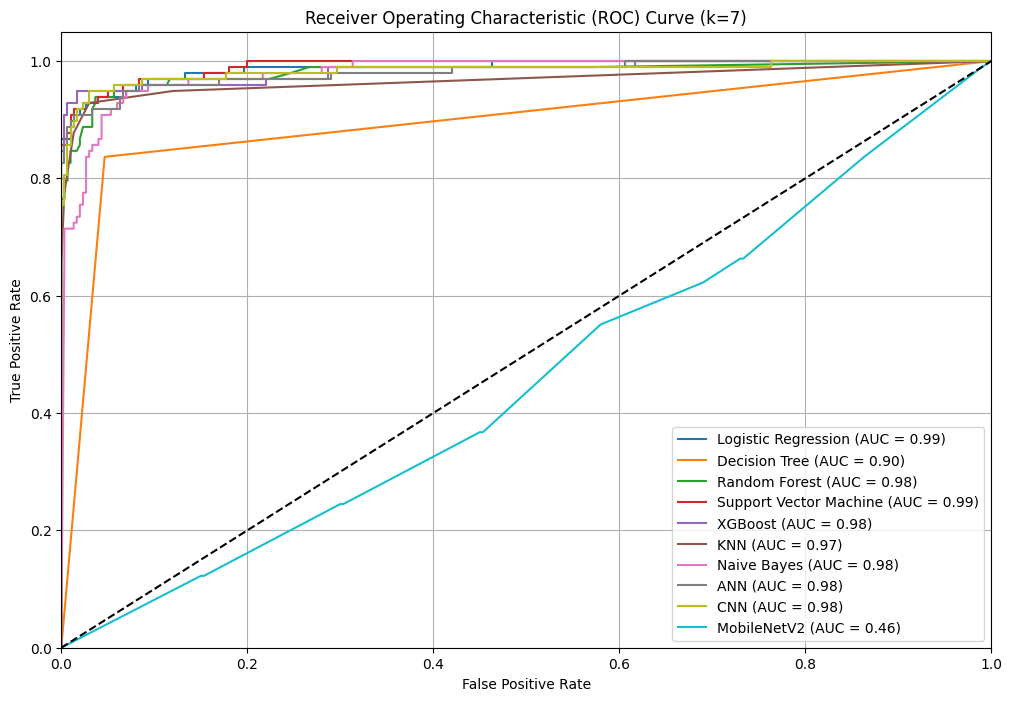

In [ ]:
# Breast Cancer Detection using Wisconsin Dataset with K-Fold Cross-Validation (k=7)
# Import all the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import Callback
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Custom callback to print epoch details
class EpochLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}: loss={logs.get('loss', 0):.4f}, accuracy={logs.get('accuracy', 0):.4f}")

# Download and set dataset path
try:
    path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
    data_path = f"{path}/data.csv"
except Exception as e:
    print(f"Error downloading dataset: {e}")
    data_path = 'data.csv'

# Read and Clean Data
try:
    df = pd.read_csv(data_path)
    print("Data loaded successfully")
except FileNotFoundError:
    print(f"File not found at {data_path}")
    exit()

df.drop(columns=['Unnamed: 32', 'id'], inplace=True, errors='ignore')

# Handle outliers
def handle_outliers(df):
    df_clean = df.copy()
    for col in df.columns[1:]:  # Skip 'diagnosis' column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

clean_df = handle_outliers(df)

# Prepare Data
X = clean_df.drop('diagnosis', axis=1)
y = clean_df['diagnosis'].map({'M': 1, 'B': 0}).values  # Convert to numpy array
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}   # k = 5 (Default)

# Results storage
cv_results = {}

# Function to create ANN model
def create_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to create CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(input_shape, 1)),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to create MobileNetV2 model
def create_mobilenet_model():
    base_model = MobileNetV2(weights=None, include_top=False, input_shape=(32, 32, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Padding function for MobileNetV2
def pad_to_min_size(X, min_height=32, min_width=32):
    samples, features = X.shape
    padded = np.zeros((samples, min_height, min_width, 3))
    num_features = min(features, min_height)
    padded[:, :num_features, 0, 0] = X[:, :num_features]
    padded[..., 1] = padded[..., 0]
    padded[..., 2] = padded[..., 0]
    return padded

# Perform 7-fold cross-validation
k = 7
kf = KFold(n_splits=k, shuffle=True, random_state=42)
print(f"\n=== K-Fold Cross-Validation with k={k} ===")

# Storage for predictions across folds
fold_results = {name: {'y_true': [], 'y_pred': [], 'y_pred_proba': []} for name in
               list(models.keys()) + ['ANN', 'CNN', 'MobileNetV2']}

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
    print(f"\nFold {fold + 1}/{k}")

    # Split data
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Prepare data for CNN and MobileNetV2
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    X_train_mobilenet = pad_to_min_size(X_train)
    X_test_mobilenet = pad_to_min_size(X_test)

    # Traditional models
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        fold_results[name]['y_true'].extend(y_test)
        fold_results[name]['y_pred'].extend(y_pred)
        fold_results[name]['y_pred_proba'].extend(y_pred_proba)

    # ANN
    ann_model = create_ann_model(X_train.shape[1])
    ann_model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0, callbacks=[EpochLogger()])
    y_pred_ann = (ann_model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
    y_pred_proba_ann = ann_model.predict(X_test, verbose=0).flatten()

    fold_results['ANN']['y_true'].extend(y_test)
    fold_results['ANN']['y_pred'].extend(y_pred_ann)
    fold_results['ANN']['y_pred_proba'].extend(y_pred_proba_ann)

    # CNN
    cnn_model = create_cnn_model(X_train_cnn.shape[1])
    cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=10, verbose=0, callbacks=[EpochLogger()])
    y_pred_cnn = (cnn_model.predict(X_test_cnn, verbose=0) > 0.5).astype(int).flatten()
    y_pred_proba_cnn = cnn_model.predict(X_test_cnn, verbose=0).flatten()

    fold_results['CNN']['y_true'].extend(y_test)
    fold_results['CNN']['y_pred'].extend(y_pred_cnn)
    fold_results['CNN']['y_pred_proba'].extend(y_pred_proba_cnn)

    # MobileNetV2
    mobilenet_model = create_mobilenet_model()
    mobilenet_model.fit(X_train_mobilenet, y_train, epochs=10, batch_size=10, verbose=0, callbacks=[EpochLogger()])
    y_pred_mobilenet = (mobilenet_model.predict(X_test_mobilenet, verbose=0) > 0.5).astype(int).flatten()
    y_pred_proba_mobilenet = mobilenet_model.predict(X_test_mobilenet, verbose=0).flatten()

    fold_results['MobileNetV2']['y_true'].extend(y_test)
    fold_results['MobileNetV2']['y_pred'].extend(y_pred_mobilenet)
    fold_results['MobileNetV2']['y_pred_proba'].extend(y_pred_proba_mobilenet)

# Print results and store for ROC
for name in fold_results:
    print(f"\n{name} (k={k}):")
    print("Classification Report:\n", classification_report(fold_results[name]['y_true'],
                                                          fold_results[name]['y_pred']))
    print("Confusion Matrix:\n", confusion_matrix(fold_results[name]['y_true'],
                                                fold_results[name]['y_pred']))
    print("-" * 50)

    cv_results[name] = {
        'y_true': fold_results[name]['y_true'],
        'y_pred': fold_results[name]['y_pred'],
        'y_pred_proba': fold_results[name]['y_pred_proba']
    }

# Plot ROC curve for k=7
plt.figure(figsize=(12, 8))
for name in cv_results:
    fpr, tpr, _ = roc_curve(cv_results[name]['y_true'], cv_results[name]['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve (k={k})')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Data loaded successfully

=== K-Fold Cross-Validation with k=7 ===

Fold 1/7
Epoch 1: loss=0.3132, accuracy=0.8974
Epoch 2: loss=0.1210, accuracy=0.9589
Epoch 3: loss=0.1017, accuracy=0.9707
Epoch 4: loss=0.1016, accuracy=0.9648
Epoch 5: loss=0.0862, accuracy=0.9707
Epoch 6: loss=0.0772, accuracy=0.9765
Epoch 7: loss=0.0687, accuracy=0.9795
Epoch 8: loss=0.0643, accuracy=0.9795
Epoch 9: loss=0.0627, accuracy=0.9824
Epoch 10: loss=0.0563, accuracy=0.9853

Fold 2/7
Epoch 1: loss=0.3041, accuracy=0.9179
Epoch 2: loss=0.1048, accuracy=0.9736
Epoch 3: loss=0.0787, accuracy=0.9795
Epoch 4: loss=0.0682, accuracy=0.9795
Epoch 5: loss=0.0618, accuracy=0.9824
Epoch 6: loss=0.0575, accuracy=0.9883
Epoch 7: loss=0.0584, accuracy=0.9824
Epoch 8: loss=0.0473, accuracy=0.9853
Epoch 9: loss=0.0427, accuracy=0.9853
Epoch 10: loss=0.0390, accuracy=0.9912

Fold 3/7
Epoch 1: loss=0.3467, accuracy=0.9150
Epoch 2: loss=0.1510, accuracy=0.9501
Epoch 3: loss=0.1150, accuracy=0.9677
Epoch 4: loss=0.1021, accur

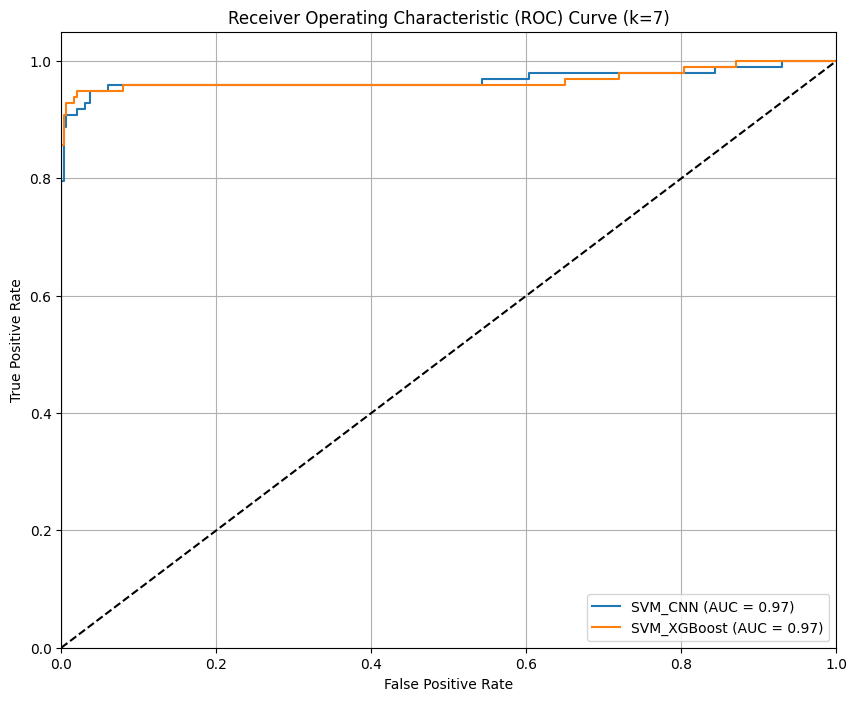

In [ ]:
# Breast Cancer Detection using Wisconsin Dataset
# K-Fold Cross-Validation (k=7)
# Classifier: SVM, Hybridization: CNN, XGBoost
# Import all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import Callback
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Custom callback to print epoch details
class EpochLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}: loss={logs.get('loss', 0):.4f}, accuracy={logs.get('accuracy', 0):.4f}")

# Download and set dataset path
try:
    path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
    data_path = f"{path}/data.csv"
except Exception as e:
    print(f"Error downloading dataset: {e}")
    data_path = 'data.csv'

# Read and Clean Data
try:
    df = pd.read_csv(data_path)
    print("Data loaded successfully")
except FileNotFoundError:
    print(f"File not found at {data_path}")
    exit()

df.drop(columns=['Unnamed: 32', 'id'], inplace=True, errors='ignore')

# Handle outliers
def handle_outliers(df):
    df_clean = df.copy()
    for col in df.columns[1:]:  # Skip 'diagnosis' column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

clean_df = handle_outliers(df)

# Prepare Data
X = clean_df.drop('diagnosis', axis=1)
y = clean_df['diagnosis'].map({'M': 1, 'B': 0}).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to create CNN model for numerical data
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(input_shape, 1)),
        MaxPooling1D(2),
        Flatten(),
        Dense(32, activation='relu', name='feature_layer'),  # Feature extraction layer
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Perform 7-fold cross-validation
k = 7
kf = KFold(n_splits=k, shuffle=True, random_state=42)
print(f"\n=== K-Fold Cross-Validation with k={k} ===")

# Storage for predictions across folds
results = {
    'SVM_CNN': {'y_true': [], 'y_pred': [], 'y_pred_proba': []},
    'SVM_XGBoost': {'y_true': [], 'y_pred': [], 'y_pred_proba': []}
}

# Process and store sample data for visualization
sample_cnn_data = []
sample_xgb_data = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
    print(f"\nFold {fold + 1}/{k}")

    # Split data
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Prepare data for CNN (add channel dimension for 1D convolution)
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Store sample data for visualization (first fold only)
    if fold == 0:
        sample_cnn_data = X_train_cnn[:5]
        sample_xgb_data = X_train[:5]

    # CNN Feature Extraction
    cnn_model = create_cnn_model(X_train.shape[1])
    cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=10, verbose=0, callbacks=[EpochLogger()])

    # Create feature extraction model after training
    feature_model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(2),
        Flatten(),
        Dense(32, activation='relu')
    ])
    # Copy weights from trained model
    for i in range(len(feature_model.layers)):
        feature_model.layers[i].set_weights(cnn_model.layers[i].get_weights())

    # Extract features
    X_train_cnn_features = feature_model.predict(X_train_cnn, verbose=0)
    X_test_cnn_features = feature_model.predict(X_test_cnn, verbose=0)

    # SVM with CNN features
    svm_cnn = SVC(probability=True)
    svm_cnn.fit(X_train_cnn_features, y_train)
    y_pred_svm_cnn = svm_cnn.predict(X_test_cnn_features)
    y_pred_proba_svm_cnn = svm_cnn.predict_proba(X_test_cnn_features)[:, 1]

    # XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    X_train_xgb_features = xgb_model.predict_proba(X_train)  # Using probability as features
    X_test_xgb_features = xgb_model.predict_proba(X_test)

    # SVM with XGBoost features
    svm_xgb = SVC(probability=True)
    svm_xgb.fit(X_train_xgb_features, y_train)
    y_pred_svm_xgb = svm_xgb.predict(X_test_xgb_features)
    y_pred_proba_svm_xgb = svm_xgb.predict_proba(X_test_xgb_features)[:, 1]

    # Store results
    results['SVM_CNN']['y_true'].extend(y_test)
    results['SVM_CNN']['y_pred'].extend(y_pred_svm_cnn)
    results['SVM_CNN']['y_pred_proba'].extend(y_pred_proba_svm_cnn)

    results['SVM_XGBoost']['y_true'].extend(y_test)
    results['SVM_XGBoost']['y_pred'].extend(y_pred_svm_xgb)
    results['SVM_XGBoost']['y_pred_proba'].extend(y_pred_proba_svm_xgb)

# Print processed sample data
print("\nSample CNN Processed Data (First 5 samples):")
for i, sample in enumerate(sample_cnn_data):
    print(f"Sample {i+1}:")
    print(sample[:5])  # Print first 5 features for brevity
    print()

print("\nSample XGBoost Input Data (First 5 samples):")
for i, sample in enumerate(sample_xgb_data):
    print(f"Sample {i+1}:")
    print(sample[:5])  # Print first 5 features for brevity
    print()

# Print results
for name in results:
    print(f"\n{name} Results:")
    print("Classification Report:")
    print(classification_report(results[name]['y_true'], results[name]['y_pred']))
    print("Confusion Matrix:")
    cm = confusion_matrix(results[name]['y_true'], results[name]['y_pred'])
    print(f"TN: {cm[0,0]}  FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]}  TP: {cm[1,1]}")
    print("-" * 50)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name in results:
    fpr, tpr, _ = roc_curve(results[name]['y_true'], results[name]['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (k=7)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()